In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter('ignore')

from dateutil.parser import parse
import multiprocessing
import pathlib
from scipy import signal
from scipy.io import wavfile
import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
#import keras
import tf_keras as tfkr
print(f"tensorflow keras version: {tfkr.__version__}")
from tensorflow.python.client import device_lib

2025-06-18 11:28:34.914334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750246115.279583      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750246115.377408      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version: 2.18.0
tensorflow keras version: 2.18.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# 1. Project Introduction #

For this project, we will load a dataset of COVID-19 related tweets spanning 2020 and 2021. Our primary objective is to build and evaluate multiple deep learning neural networks capable of analyzing the sentiment (positive, negative, or neutral) expressed in each tweet. A key aspect of this work will involve comparing the prediction performance of these different models and try to understand the underlying reasons to the performance difference.

## 1.1 Data Description ## 

The dataset comes from kaggle: [Covid-19 Twitter Dataset](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset). It collects world-wide Covid-19 related english tweets in three different phases, which are packed into three separate dataframes respectively:
* from 2020-04 to 2020-06
* from 2020-08 to 2020-10
* from 2021-04 to 2021-06

Each data in the dataframe contains following columns:
* Tweet ID
* Creation Date & Time
* Source Link
* Original Tweet
* Favorite Count
* Retweet Count
* Original Author
* Hashtags
* User Mentions
* Place
* clean_tweet
* sentiment

The column **clean_tweet** is a text preprocessing for **Original Tweet**, whereby several techniques were utilized including: lower-casing all letters, removing all extra spaces, punctuations, stop-words, numbers, URLs etc.  

Column **sentiment** is the target our model shall learn. It yiels 3 different values: positive, negative and neutral.

In [3]:
import kagglehub

# Download latest version
original_datapath = kagglehub.dataset_download("arunavakrchakraborty/covid19-twitter-dataset")

print("Path to dataset files:", original_datapath)

Path to dataset files: /kaggle/input/covid19-twitter-dataset


# 2. Data Preprocessing #

The most relevant feature to analyzing sentiment is **clean_tweet**. However by looking into the text in this column, it contains considerably amount of spelling errors. It will cause at least two problems:
1. It significantly diminishes data interpretability, hindering effective understanding of the textual content.
2. It contributes to an unnecessary expansion of the vocabulary size and thus will increase computation complexity of DL model.

In [4]:
orig_data_1 = pd.read_csv(os.path.join(original_datapath, "/kaggle/input/covid19-twitter-dataset/Covid-19 Twitter Dataset (Apr-Jun 2020).csv"))
random_tweets = orig_data_1.sample(n=3)
print(random_tweets['clean_tweet'])

138831                       german politician talk covid19
48601     let talk realiti one person covid19 societi re...
48690     covid19 uk govern refus share rapid test site ...
Name: clean_tweet, dtype: object


To address these challenges and for gaining my own practical experience, I completely re-preprocessed the original text. This involved using the **NLTK** Python package for tokenization and pruning, and **pyspellchecker** for detecting spelling errors. The detailed steps are:
* remove retweet string "RT"
* remove mentions (token beginning with '@')
* lower-case text
* remove hashtags (beginning with '#')
* remove URLs
* remove all special characters, including punctuations.
* remove all wrongly spelled words
* lemmatize all tokens, here the part-of-speech (POS) tag for each word is considered
* remove numbers
* remove stopwords

In this work, the mistakenly spelled words will be just removed instead of being corrected, in order to further shrink the data size and speed up training.

The source code for re-preprocessing tweets is not depicted in this lab. Instead the reworked datasets are directly provided in the workspace. 

In [5]:
datapath = "/kaggle/input/tweets-covid19-dataset-preprocessed"
tweet_data_1 = pd.read_csv(os.path.join(datapath, "processed_tweets_1_updated.csv"))
tweet_data_1_backup = tweet_data_1.copy()
tweet_data_2 = pd.read_csv(os.path.join(datapath, "processed_tweets_2_updated.csv"))
tweet_data_2_backup = tweet_data_2.copy()
tweet_data_3 = pd.read_csv(os.path.join(datapath, "processed_tweets_3_updated.csv"))
tweet_data_3_backup = tweet_data_3.copy()

We randomly chose 3 data from the entire dataset and observed that the reworked clean tweet (column **processed_text**) yield more comprehensive text than before.

In [6]:
random_tweets = tweet_data_1.sample(n=3)
for i in range(3):
    #print(f"ORIGINAL TWEET {i}: {random_tweets.iloc[i]['original_text']}")
    print(f"ORIGINAL CLEAN TWEET {i}: {random_tweets.iloc[i]['clean_tweet']}")
    print(f"REWORKED CLEAN TWEET {i}: {random_tweets.iloc[i]['processed_text']}")

ORIGINAL CLEAN TWEET 0: think absolut comprehend ideolog attack woman treasuri say
REWORKED CLEAN TWEET 0: think absolutely comprehend ideological attack woman treasury say
ORIGINAL CLEAN TWEET 1: report covid19 threat heavier state test
REWORKED CLEAN TWEET 1: report covid threat heavier state testing
ORIGINAL CLEAN TWEET 2: glossari covid19 pandem help use right write
REWORKED CLEAN TWEET 2: glossary covid pandemic help use right write


To ease the analysis, we will not distinguish the 3 dataframes corresponding to 3 phases of tweets dates, but concatenating them into one dataframe. Following cells give an overview:

In [7]:
# Concatenate the three dataframes into one
tweet_data = pd.concat([tweet_data_1, tweet_data_2, tweet_data_3], ignore_index=True)
tweet_data.head(5)

,created_at,original_text,favorite_count,retweet_count,original_author,hashtags,place,clean_tweet,compound,neg,neu,pos,sentiment,text_len,processed_text,is_retweet,tokens_count,spell_error_count,spell_error_words,unknown_words
0,2020-04-19,RT @GlblCtzn: .@priyankachopra is calling on l...,0.0,31.0,RJIshak,NaN,Jakarta Capital Region,call leader help protect refuge covid19 provid...,0.8176,0.0,0.452,0.548,pos,139,call leader help protect refugee covid provide...,True,10.0,0.0,NaN,NaN
1,2020-04-19,RT @OGSG_Official: OGUN STATE SUPPORT FOR CBN-...,0.0,61.0,makinwaoluwole,NaN,Nigeria,ogun state support cbn nirsal covid19 target c...,0.6486,0.0,0.602,0.398,pos,116,state support covid target credit facility,True,6.0,3.0,"ogun, cbn-nirsal, tcf",NaN
2,2020-04-19,RT @AdvoBarryRoux: These 5 police officials ba...,0.0,1.0,TembeAmu,NaN,NaN,polic offici base namahadi polic station busi ...,0.2732,0.0,0.851,0.149,pos,139,police official base police station busy drink...,True,12.0,1.0,namahadi,NaN
3,2020-04-19,RT @MobilePunch: COVID-19: Oyo discharges two ...,0.0,0.0,ilyasrabiu,NaN,"Lagos, Nigeria",covid19 oyo discharg two patient,0.0000,0.0,1.000,0.000,neu,78,covid discharge two patient,True,4.0,1.0,oyo,NaN
4,2020-04-19,My Condolences to the Family of those who did ...,0.0,13869.0,bucketeconomist,covid_19,NaN,condol famili surviv,0.0000,0.0,1.000,0.000,neu,68,condolence family survive,False,3.0,0.0,NaN,NaN


In [8]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411884 entries, 0 to 411883
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   created_at         411884 non-null  object 
 1   original_text      411884 non-null  object 
 2   favorite_count     411884 non-null  float64
 3   retweet_count      411884 non-null  float64
 4   original_author    411884 non-null  object 
 5   hashtags           101125 non-null  object 
 6   place              293775 non-null  object 
 7   clean_tweet        409914 non-null  object 
 8   compound           411884 non-null  float64
 9   neg                411884 non-null  float64
 10  neu                411884 non-null  float64
 11  pos                411884 non-null  float64
 12  sentiment          411884 non-null  object 
 13  text_len           411884 non-null  int64  
 14  processed_text     409465 non-null  object 
 15  is_retweet         411884 non-null  bool   
 16  to

It is noted that some data at **processed_text** are null, because the original tweet might contain only "nonsense" words which are not recognized by pyspellchecker. Those data rows will be dropped. 

In [9]:
#drop_columns = ['id', 'source', 'lang']
drop_columns = ['place', 'original_author']
#dropna_columns = ['original_text', 'clean_tweet', 'lang']
dropna_columns = ['original_text', 'clean_tweet', 'processed_text']
tweet_data.dropna(subset=dropna_columns, how='any', axis=0, inplace=True)
tweet_data.drop(columns=drop_columns, inplace=True)

# Display the shape of the combined dataframe
tweet_data.shape

(409449, 18)

In addition, we can confirm that column **sentiment** contains only 3 data values: neu, pos and neg. Because the sum of these 3 values equals the number of rows of the dataframe.

In [10]:
print(tweet_data['sentiment'].value_counts())
print(tweet_data['sentiment'].value_counts().sum())

sentiment
neu    172508
pos    127329
neg    109612
Name: count, dtype: int64
409449


Using CountVectorizer class from sklearn, we can evaluate that the reworked preprocessed texts has reduced the vocabulary size (number of BOW) by more than 50%.

In [11]:
count_vectorizer = CountVectorizer(ngram_range=(1,1))
all_tweets = tweet_data['processed_text']
all_tweets_bow = count_vectorizer.fit_transform(all_tweets)
print(f"Vocabulary size of reworked clean tweets: {all_tweets_bow.shape[1]}")
count_vectorizer = CountVectorizer(ngram_range=(1,1))
all_tweets = tweet_data['clean_tweet']
all_tweets_bow = count_vectorizer.fit_transform(all_tweets)
print(f"Vocabulary size of original clean tweets: {all_tweets_bow.shape[1]}")

Vocabulary size of reworked clean tweets: 32849
Vocabulary size of original clean tweets: 81799


# 3. Model Training & Testing #

In this work, we only use **processed_text** as text sequence for feature data, and **sentiment** as label for supervised deep learning. 

In order to avoid data-leakage by introducing futural tweets into training set, we choose all tweets before date 2021-06-01 as training dataset, tweets after this date as test set.  

In [12]:
criterion_test = pd.to_datetime(tweet_data['created_at']) >= pd.Timestamp('2021-06-01')
criterion_train = pd.to_datetime(tweet_data['created_at']) < pd.Timestamp('2021-06-01')

tweet_data_test = tweet_data[criterion_test.values]
tweet_data_train = tweet_data[criterion_train.values]

X = tweet_data['processed_text']
y = tweet_data['sentiment']
# perform one-hot conversion to y
y = pd.get_dummies(y).astype(float)
# prompt: convert y values from true/false to 1/0

X_train = tweet_data_train['processed_text']
X_test = tweet_data_test['processed_text']
y_train = tweet_data_train['sentiment']
y_test = tweet_data_test['sentiment']
y_train = pd.get_dummies(y_train).astype(float)
y_test = pd.get_dummies(y_test).astype(float)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (342670,)
Shape of X_test: (66779,)
Shape of y_train: (342670, 3)
Shape of y_test: (66779, 3)


### Preparations & Helper Functions ###

To increase readability, we define a function which performs prediction on test dataset with a model and prints out the accuracy and mean categorical crossentropy as loss.

In [13]:
def get_prediction_result(X_test, y_test, model):
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred_sent = np.argmax(y_pred, axis=1)
    y_test_sent = np.argmax(y_test.to_numpy(), axis=1)
    # prompt: calculate the accuracy for y_pred
    accuracy = np.mean(y_pred_sent == y_test_sent)
    print(f"Accuracy: {accuracy}")
    loss = tf.keras.losses.categorical_crossentropy(y_test.to_numpy(), y_pred)
    loss_mean = np.mean(loss)
    print(f"Loss: {loss_mean}")
    return accuracy, loss_mean

We use the same funcion for model training, in which cross validation is performed and the training data are shuffled at each epoch. In addition, following callbacks are utilized:
* keras standard callback **EarlyStopping** to avoid overfitting, in which the training will stop when the validation loss did not improve in the last 3 epochs (patience=3). But the parameters at the epoch with the best loss score will be restored.
* A manually defined callback class **EpochTimingCallback**, where the training time for each epoch will be stored for further analysis.

In [14]:
import time
# --- Custom Callback to Measure Epoch Duration ---
class EpochTimingCallback(tfkr.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time() # Record start time at the beginning of the epoch

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        duration = end_time - self.start_time
        self.epoch_times.append(duration)


In [15]:
from tf_keras.callbacks import EarlyStopping
def train_model(model, X_train, y_train, epochs=20, val_split=0.2, batch_size=256):
    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    epoch_timer = EpochTimingCallback()
    callbacks_list = [early_stop, epoch_timer]
    history = model.fit(X_train, y_train, epochs=epochs, 
                                  validation_split=val_split, batch_size=batch_size, shuffle=False, 
                                  callbacks=callbacks_list)
    history.history['epoch_duration_sec'] = epoch_timer.epoch_times
    return history

Finally, we define a function to plot the accuracy and loss history data during training.

In [16]:
import matplotlib.pyplot as plt

history_all = []
model_all = []
test_accuracy_all = {}
test_loss_all = {}

def plot_model_train_validation_history(history):
    plt.figure(figsize=(15, 6))
    
    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['accuracy'], label=f'Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy', linestyle='--')
    plt.title(f'Model {history.model.name}: Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Train Loss')
    plt.plot(history.history['val_loss'], label=f'Val Loss', linestyle='--')
    plt.title(f'Model {history.model.name}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed
    
    return

## 3.1 Embedding Based Models ##

We're starting our exploration with embedding-based neural networks. Since these models require text or word sequences as input, their initial layer consistently uses Keras's **TextVectorization** layer. This layer serves two key purposes:
1. It assigns a unique integer to each word, ordering these integers by word frequency.
2. It converts the input text into sequences of these integers.

To ensure all vocabularies from every tweet are covered, we've set the **max_tokens** parameter to a value slightly exceeding the total vocabulary size. And since the preprocessed tweets have at most 26 tokens, we've set **output_sequence_length** to 30. After the instantiation, the **TextVectorization** layer is adapted using all tweets, allowing it to learn every word present across both the training and holdout sets.

In [17]:
print(f"longest tweet has {tweet_data['tokens_count'].max()} words")

longest tweet has 26.0 words


In [18]:
from tf_keras import layers
VOCAB_SIZE = 35000
OUTPUT_SEQUENCE_LENGTH = 30
BATCH_SIZE = 256

X_list = X.to_numpy()


text_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    split='whitespace',
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
)
text_vectorize_layer.adapt(X_list)
vocabulary_all = text_vectorize_layer.get_vocabulary()
print(f"Vocabulary size: {len(vocabulary_all)}")

X_train_ds = X_train.to_numpy()
X_test_ds = X_test.to_numpy()

I0000 00:00:1750246149.915485      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750246149.916122      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Vocabulary size: 32853


Next, we will construct various simple sequential models. Beyond the **TextVectorization** layer, each model will commonly include an **Embedding** layer, which maps all vocabularies into a 2-dimensional space.

### 3.1.1 Fully-Connected Model ###

Following the **Embedding** layer, this model incorporates a 16-unit fully connected (**Dense**) layer, utilizing a ReLU activation function. The final output is then generated by a 3-unit Dense layer with a sigmoid activation, which provides the probabilities for positive, negative, and neutral sentiment classifications.

In [19]:
EMBED_OUT_DIM = 2
EMBED_IN_DIM = VOCAB_SIZE
DENSE_HIDDEN_DIM = 16
tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_vectorize_layer(tweet_input)
x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
x = layers.Flatten()(x)
#x = layers.Reshape((-1,))(x)
x = layers.Dense(DENSE_HIDDEN_DIM, activation='relu')(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_full = tfkr.Model(tweet_input, x, name='Full_Connect_Embedding')
model_full.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_full.summary()

Model: "Full_Connect_Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 30, 2)             70000     
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 16)                976       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                            

The training history for this model shows that the accuracies has reached ~95% for both training and validation sets after only 6 epochs.

Epoch 1/20


I0000 00:00:1750246187.008496      61 service.cc:148] XLA service 0x79e6b9f6b450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750246187.009813      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750246187.009833      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750246187.142442      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750246187.352285      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1071/1071 [==============================] - 40s 33ms/step - loss: 0.4980 - accuracy: 0.8064 - val_loss: 0.2405 - val_accuracy: 0.9339
Epoch 2/20
1071/1071 [==============================] - 5s 5ms/step - loss: 0.1826 - accuracy: 0.9527 - val_loss: 0.2071 - val_accuracy: 0.9474
Epoch 3/20
1071/1071 [==============================] - 5s 5ms/step - loss: 0.1526 - accuracy: 0.9622 - val_loss: 0.2043 - val_accuracy: 0.9493
Epoch 4/20
1071/1071 [==============================] - 5s 5ms/step - loss: 0.1392 - accuracy: 0.9659 - val_loss: 0.2069 - val_accuracy: 0.9490
Epoch 5/20
1071/1071 [==============================] - 5s 5ms/step - loss: 0.1310 - accuracy: 0.9682 - val_loss: 0.2111 - val_accuracy: 0.9477
Epoch 6/20
1071/1071 [==============================] - 5s 5ms/step - loss: 0.1253 - accuracy: 0.9698 - val_loss: 0.2159 - val_accuracy: 0.9464


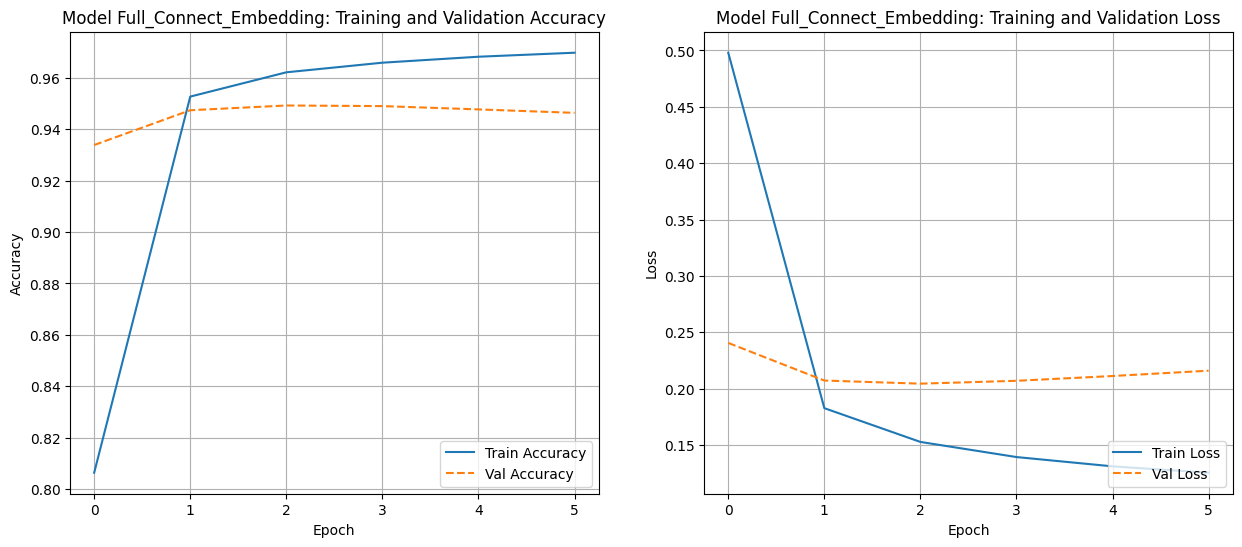

In [20]:
history_full = train_model(model_full, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_full)
model_all.append(model_full)
plot_model_train_validation_history(history_full)

The prediction for test dataset also yields a high accuracy ~95%. 

In [21]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_full)
test_accuracy_all.update({model_full.name: acc})
test_loss_all.update({model_full.name: loss})

261/261 [==============================] - 1s 2ms/step
Accuracy: 0.9523952140643016
Loss: 0.3967122435569763


### 3.1.2 Simple RNN Model ###

In this model, we replace the previous fully connected layer with a **SimpleRNN** layer. This RNN layer features 16 state units and uses **tanh** as its activation function, enabling the model to learn context from preceding terms for each current word.

In [22]:
EMBED_OUT_DIM = 2
EMBED_IN_DIM = VOCAB_SIZE
RNN_HIDDEN_DIM = 16
tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_vectorize_layer(tweet_input)
x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
x = layers.SimpleRNN(RNN_HIDDEN_DIM, kernel_initializer=tfkr.initializers.RandomNormal(stddev=0.001),  
                     recurrent_initializer=tfkr.initializers.Identity(gain=1.0), activation='tanh')(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_rnn = tfkr.Model(tweet_input, x, name = 'Simple_RNN')
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 30, 2)             70000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                304       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 70355 (274.82 KB)
Trainable params: 70355 (274.82 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Unlike the fully-connected model, the training for the RNN model converged much slower (~10 epochs) before reaching an accuracy of ~95%.

Epoch 1/20
1071/1071 [==============================] - 52s 46ms/step - loss: 0.5716 - accuracy: 0.7393 - val_loss: 0.4044 - val_accuracy: 0.8677
Epoch 2/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.2582 - accuracy: 0.9216 - val_loss: 0.2203 - val_accuracy: 0.9377
Epoch 3/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.1724 - accuracy: 0.9543 - val_loss: 0.2390 - val_accuracy: 0.9292
Epoch 4/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.1532 - accuracy: 0.9611 - val_loss: 0.2208 - val_accuracy: 0.9382
Epoch 5/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.1450 - accuracy: 0.9637 - val_loss: 0.2118 - val_accuracy: 0.9432
Epoch 6/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.1394 - accuracy: 0.9658 - val_loss: 0.2181 - val_accuracy: 0.9431
Epoch 7/20
1071/1071 [==============================] - 28s 26ms/step - loss: 0.1358 - accuracy: 0.9667 - val_loss: 0.2283 -

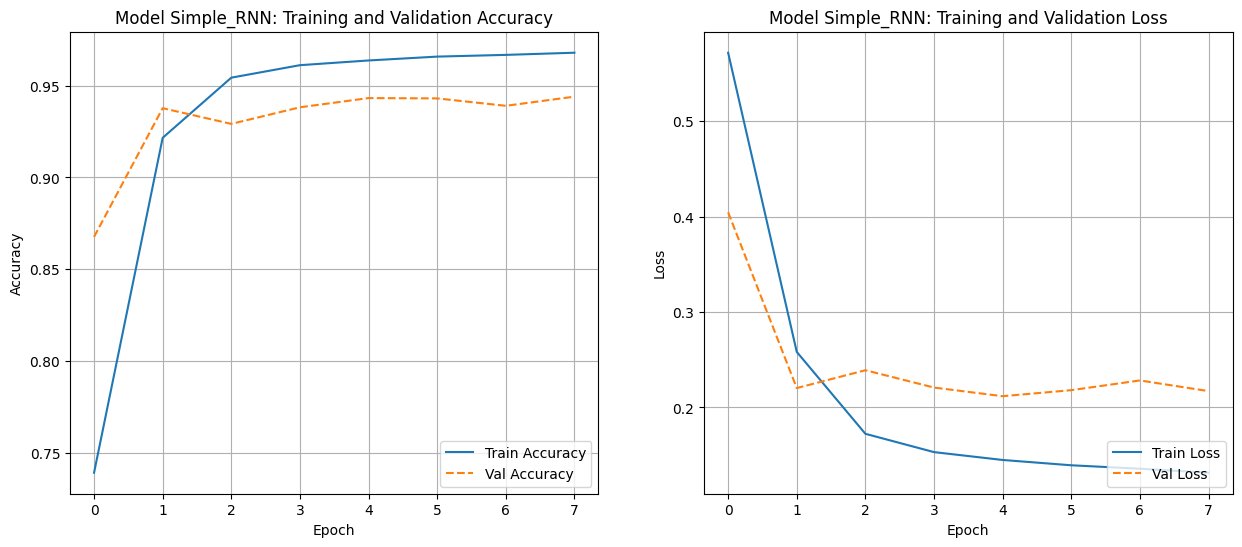

In [23]:
history_rnn = train_model(model_rnn, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_rnn)
model_all.append(model_rnn)
plot_model_train_validation_history(history_rnn)

The prediction for test dataset also yields a high accuracy ~95%.

In [24]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_rnn)
test_accuracy_all.update({model_rnn.name: acc})
test_loss_all.update({model_rnn.name: loss})

261/261 [==============================] - 1s 4ms/step
Accuracy: 0.9481274053220323
Loss: 0.388776034116745


### 3.1.3 LSTM Model ###

This model utilized a **LSTM** layer instead of **SimpleRNN**, in order to enhance the learning of the long-term preceding context for each word input. Although we used again 16 hidden states, the **LSTM** layer contains 4 times as many weights as **SimpleRNN**.

In [25]:
EMBED_OUT_DIM = 2
EMBED_IN_DIM = VOCAB_SIZE
RNN_HIDDEN_DIM = 16
tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_vectorize_layer(tweet_input)
x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
x = layers.LSTM(units=RNN_HIDDEN_DIM)(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_lstm = tfkr.Model(tweet_input, x, name = 'LSTM')
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 30, 2)             70000     
                                                                 
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 71267 (278.39 KB)
Trainable params: 71267 (278.39 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

Due to its inherent complexity, the LSTM model required even more epochs (typically over 10) than the Simple RNN model to stabilize its validation loss. Consequently, it also achieved ~95% accuracy on both the training and validation sets at a slower pace.

Epoch 1/20
1071/1071 [==============================] - 31s 26ms/step - loss: 0.6032 - accuracy: 0.7161 - val_loss: 0.3759 - val_accuracy: 0.8771
Epoch 2/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.2826 - accuracy: 0.9102 - val_loss: 0.2735 - val_accuracy: 0.9201
Epoch 3/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.2246 - accuracy: 0.9364 - val_loss: 0.2588 - val_accuracy: 0.9253
Epoch 4/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.2002 - accuracy: 0.9445 - val_loss: 0.2457 - val_accuracy: 0.9295
Epoch 5/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.1847 - accuracy: 0.9492 - val_loss: 0.2318 - val_accuracy: 0.9358
Epoch 6/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.1707 - accuracy: 0.9537 - val_loss: 0.2321 - val_accuracy: 0.9350
Epoch 7/20
1071/1071 [==============================] - 7s 7ms/step - loss: 0.1597 - accuracy: 0.9571 - val_loss: 0.2262 - val_accurac

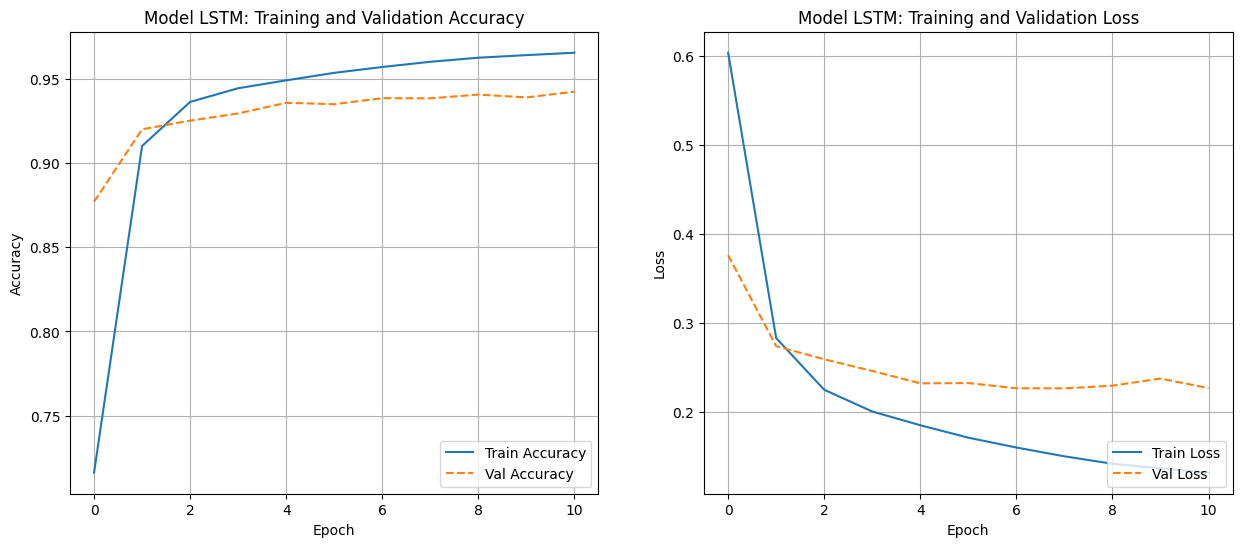

In [26]:
history_lstm = train_model(model_lstm, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_lstm)
model_all.append(model_lstm)
plot_model_train_validation_history(history_lstm)

The accuracy on test set yielded a similar good result ~95% as before.

In [27]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_lstm)
test_accuracy_all.update({model_lstm.name: acc})
test_loss_all.update({model_lstm.name: loss})

261/261 [==============================] - 1s 3ms/step
Accuracy: 0.9424070441306399
Loss: 0.4314119517803192


### 3.1.4 CNN Model ###

We're now testing an alternative strategy that focuses on analyzing n-grams surrounding each word. To implement this, we sequentially applied two 1D-CNN layers, both featuring a kernel size of 5. This design ensures a receptive field of 9 n-grams for every word. For both layers, 'full' padding was used, and ReLU served as the activation function.

Subsequently, a global maximum operation will be performed on the output of the CNN layers, evaluated across the word sequence dimension.

In [28]:
EMBED_OUT_DIM = 2
EMBED_IN_DIM = VOCAB_SIZE
CNN_1_SIZE = 5
CNN_1_FILTERS = 24
CNN_2_SIZE = 5
CNN_2_FILTERS = 12


tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_vectorize_layer(tweet_input)
x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
x = layers.Conv1D(filters=CNN_1_FILTERS, kernel_size=CNN_1_SIZE, padding="same", activation='relu')(x)
x = layers.Conv1D(filters=CNN_2_FILTERS, kernel_size=CNN_2_SIZE, padding="same", activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_cnn = tfkr.Model(tweet_input, x, name = 'CNN')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 30, 2)             70000     
                                                                 
 conv1d (Conv1D)             (None, 30, 24)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 12)            1452      
                                                                 
 global_max_pooling1d (Glob  (None, 12)                0         
 alMaxPooling1D)                                               

The training of this CNN model yielded a fast convergence: no improvement of validation loss within ~5 epochs.

Epoch 1/20
1071/1071 [==============================] - 30s 25ms/step - loss: 0.4078 - accuracy: 0.8433 - val_loss: 0.2173 - val_accuracy: 0.9461
Epoch 2/20
1071/1071 [==============================] - 6s 6ms/step - loss: 0.1799 - accuracy: 0.9558 - val_loss: 0.2052 - val_accuracy: 0.9488
Epoch 3/20
1071/1071 [==============================] - 6s 5ms/step - loss: 0.1673 - accuracy: 0.9591 - val_loss: 0.2053 - val_accuracy: 0.9479
Epoch 4/20
1071/1071 [==============================] - 6s 5ms/step - loss: 0.1598 - accuracy: 0.9612 - val_loss: 0.2069 - val_accuracy: 0.9467
Epoch 5/20
1071/1071 [==============================] - 6s 5ms/step - loss: 0.1531 - accuracy: 0.9628 - val_loss: 0.2090 - val_accuracy: 0.9453


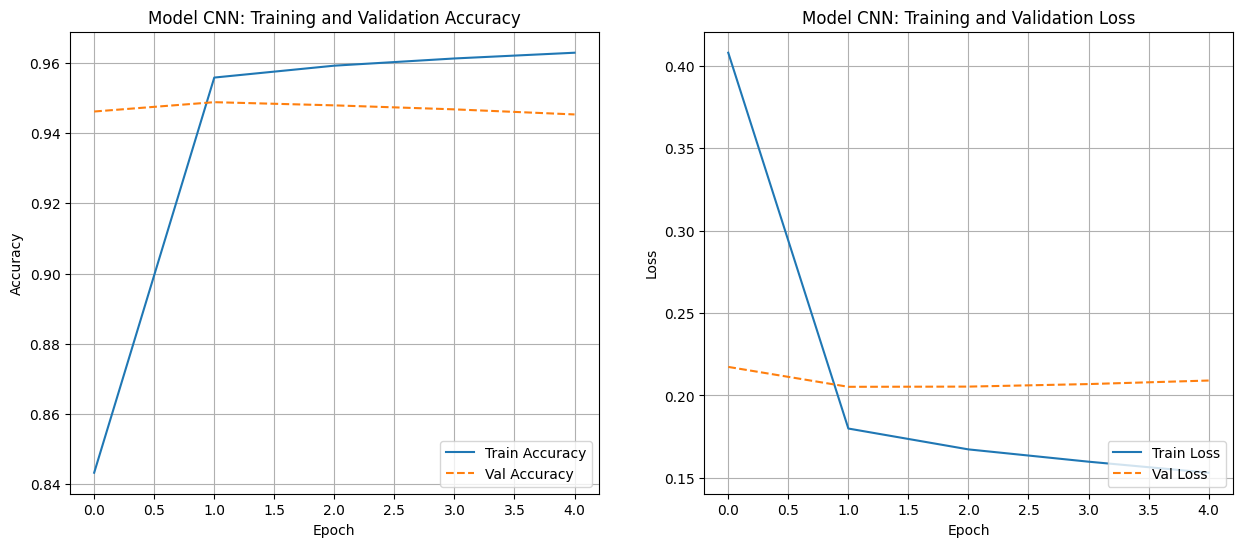

In [29]:
history_cnn = train_model(model_cnn, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_cnn)
model_all.append(model_cnn)
plot_model_train_validation_history(history_cnn)

The test accuracy yielded a similar good result (~95%) as before.

In [30]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_cnn)
test_accuracy_all.update({model_cnn.name: acc})
test_loss_all.update({model_cnn.name: loss})

261/261 [==============================] - 1s 3ms/step
Accuracy: 0.9508827625451115
Loss: 0.2725829482078552


### 3.1.5 CNN-RNN Hybrid Model ###

This model combines CNN and LSTM architectures. First, we use a 1D-CNN layer to learn the surrounding context for each word. Then, an LSTM layer is added to capture the sequential dependencies from preceding content relative to the current n-gram.

In [31]:
EMBED_OUT_DIM = 2
EMBED_IN_DIM = VOCAB_SIZE
CNN_1_SIZE = 5
CNN_1_FILTERS = 16
RNN_HIDDEN_DIM = 12


tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_vectorize_layer(tweet_input)
x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
x = layers.Conv1D(filters=CNN_1_FILTERS, kernel_size=CNN_1_SIZE, padding="same", activation='relu')(x)
x = layers.LSTM(units=RNN_HIDDEN_DIM)(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_hyb = tfkr.Model(tweet_input, x, name='CNN_LSTM_Hybrid')
model_hyb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hyb.summary()

Model: "CNN_LSTM_Hybrid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 30, 2)             70000     
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 16)            176       
                                                                 
 lstm_1 (LSTM)               (None, 12)                1392      
                                                                 
 dense_5 (Dense)             (None, 3)                 39        
                                                   

The training of this model has reached ~95% for both training and validation set like previous models, but converged a bit slower than the pure CNN model.

Epoch 1/20
1071/1071 [==============================] - 32s 27ms/step - loss: 0.5599 - accuracy: 0.7360 - val_loss: 0.3242 - val_accuracy: 0.9095
Epoch 2/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.2798 - accuracy: 0.9186 - val_loss: 0.2719 - val_accuracy: 0.9179
Epoch 3/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.2280 - accuracy: 0.9312 - val_loss: 0.2429 - val_accuracy: 0.9288
Epoch 4/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.1986 - accuracy: 0.9438 - val_loss: 0.2279 - val_accuracy: 0.9323
Epoch 5/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.1816 - accuracy: 0.9502 - val_loss: 0.2371 - val_accuracy: 0.9301
Epoch 6/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.1707 - accuracy: 0.9543 - val_loss: 0.2261 - val_accuracy: 0.9358
Epoch 7/20
1071/1071 [==============================] - 8s 7ms/step - loss: 0.1644 - accuracy: 0.9565 - val_loss: 0.2261 - val_accurac

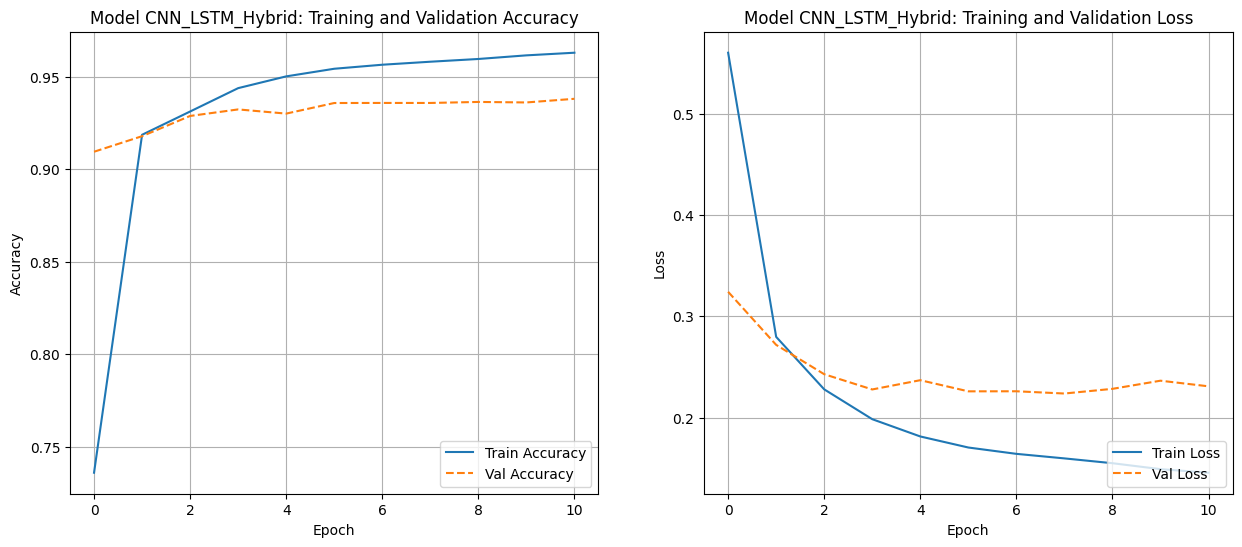

In [32]:
history_hyb = train_model(model_hyb, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_hyb)
model_all.append(model_hyb)
plot_model_train_validation_history(history_hyb)

Predition on test set: similar accuracy ~95% as before.

In [33]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_hyb)
test_accuracy_all.update({model_hyb.name: acc})
test_loss_all.update({model_hyb.name: loss})

261/261 [==============================] - 1s 3ms/step
Accuracy: 0.9397115859776277
Loss: 0.4283145070075989


## 3.2 TF-IDF Based Models ##

We observed that all embedding-based models in the previous section have reached nearly the same good prediction accuracy on test-set. Now a question arises: does the sentiment classification rely on the word sequence? will the context for each term influence the overall sentiment of the tweet?

To explore this, we're adopting a completely different strategy: vectorizing tweet text into a TF-IDF array. Each element in this array represents a word's occurrence, weighted by the inverse of its appearance frequency across all documents. Here, the **TextVectorization** layer is leveraged again, but with "tf_idf" as **output_mode**. 

In [34]:
from tf_keras import layers
VOCAB_SIZE_TFIDF = 35000

text_tfidf_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE_TFIDF,
    output_mode="tf_idf",
    split='whitespace'
)
text_tfidf_layer.adapt(X_list)
vocabulary_tfidf = text_tfidf_layer.get_vocabulary()
print(f"Vocabulary size: {len(vocabulary_tfidf)}")


Vocabulary size: 32852


The following cell shows an example of the output of TF-IDF vectorization, the dimension of which equals the vocabulary size.

In [35]:
X_demo = X_list[0:2]
test_tfidf_input = tf.convert_to_tensor(X_demo[1], dtype=tf.string)
test_tfidf_output = text_tfidf_layer(test_tfidf_input)
print(test_tfidf_output)

tf.Tensor([0.        1.0620592 0.        ... 0.        0.        0.       ], shape=(32852,), dtype=float32)


### 3.2.1 Fully-Connected TF-IDF Model ###

Since TF-IDF vectorization inherently discards word context, it is no longer meaningful to employ context-aware layers (e.g., RNN, CNN). Here, we test only a simple fully-connected model based on the TF-IDF input. The model summary reveals that even this simplest fully-connected model, with just an 8-output **Dense** layer, consumes significantly more parameters (approximately 260K) than the embedding-based models (around 70K).

In [36]:
#EMBED_OUT_DIM = 2
#EMBED_IN_DIM = VOCAB_SIZE
DENSE1_HIDDEN_DIM = 256
DENSE2_HIDDEN_DIM = 32
DENSE3_HIDDEN_DIM = 8
tweet_input = tfkr.Input(shape=(1,), dtype=tf.string)
x = text_tfidf_layer(tweet_input)
#x = layers.Embedding(input_dim=EMBED_IN_DIM, output_dim=EMBED_OUT_DIM, mask_zero=False)(x)
#x = layers.Flatten()(x)
#x = layers.Reshape((-1,))(x)
#x = layers.Dense(DENSE1_HIDDEN_DIM, activation='relu')(x)
#x = layers.Dense(DENSE2_HIDDEN_DIM, activation='relu')(x)
x = layers.Dense(DENSE3_HIDDEN_DIM, activation='relu')(x)
x = layers.Dense(3, activation='sigmoid')(x)
model_tfidf = tfkr.Model(tweet_input, x, name='TF_IDF_Embedding')
model_tfidf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_tfidf.summary()

Model: "TF_IDF_Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 32852)             1         
 Vectorization)                                                  
                                                                 
 dense_6 (Dense)             (None, 8)                 262824    
                                                                 
 dense_7 (Dense)             (None, 3)                 27        
                                                                 
Total params: 262852 (1.00 MB)
Trainable params: 262851 (1.00 MB)
Non-trainable params: 1 (8.00 Byte)
_________________________________________________________________


Astonishingly, the model trained exceptionally fast, with validation loss stabilizing in under 5 epochs, and achieved the same strong accuracy of approximately 95% as the embedding models.

Epoch 1/20
1071/1071 [==============================] - 14s 12ms/step - loss: 0.3388 - accuracy: 0.9029 - val_loss: 0.2131 - val_accuracy: 0.9455
Epoch 2/20
1071/1071 [==============================] - 12s 11ms/step - loss: 0.1551 - accuracy: 0.9609 - val_loss: 0.2044 - val_accuracy: 0.9472
Epoch 3/20
1071/1071 [==============================] - 12s 11ms/step - loss: 0.1259 - accuracy: 0.9680 - val_loss: 0.2104 - val_accuracy: 0.9470
Epoch 4/20
1071/1071 [==============================] - 12s 11ms/step - loss: 0.1095 - accuracy: 0.9716 - val_loss: 0.2197 - val_accuracy: 0.9455
Epoch 5/20
1071/1071 [==============================] - 12s 11ms/step - loss: 0.0976 - accuracy: 0.9745 - val_loss: 0.2317 - val_accuracy: 0.9434


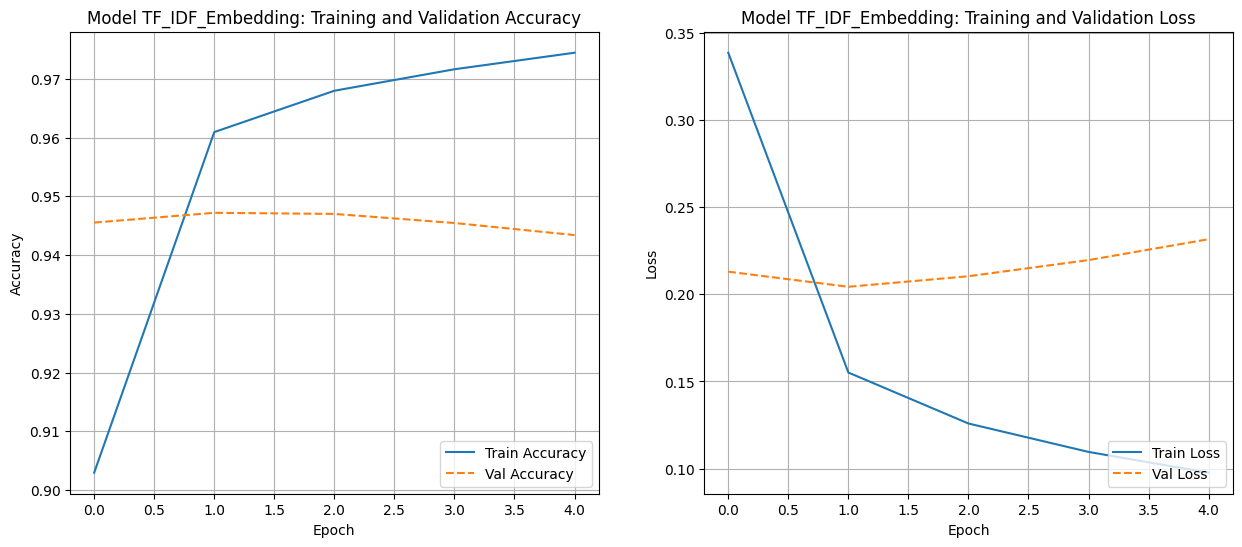

In [37]:
history_tfidf = train_model(model_tfidf, X_train_ds, y_train, epochs=20, val_split=0.2, batch_size=BATCH_SIZE)
history_all.append(history_tfidf)
model_all.append(model_tfidf)
plot_model_train_validation_history(history_tfidf)

The test accuracy is also as good as the embedding models.

In [38]:
acc, loss = get_prediction_result(X_test_ds, y_test, model_tfidf)
test_accuracy_all.update({model_tfidf.name: acc})
test_loss_all.update({model_tfidf.name: loss})

261/261 [==============================] - 2s 7ms/step
Accuracy: 0.9511223588253792
Loss: 0.3077699542045593


## 3.3 Models Comparison ##

The graphs below show and compare the diverse metrics of training histories for different models:

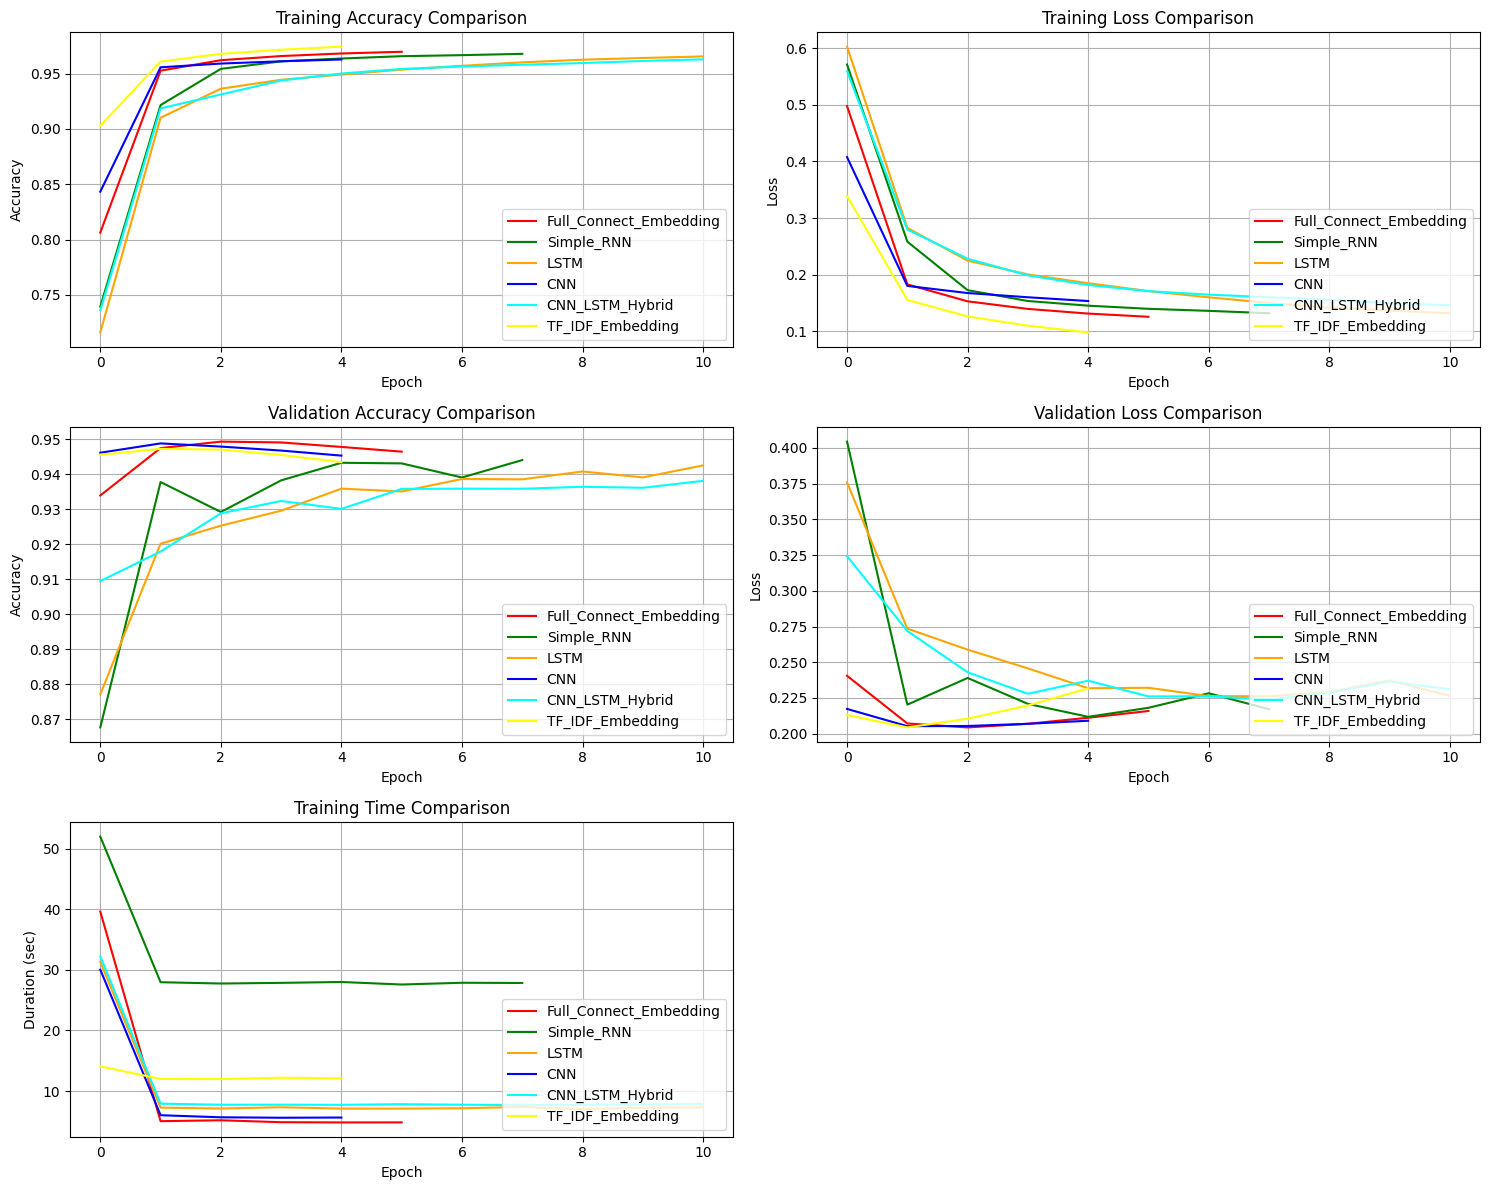

In [39]:
plt.figure(figsize=(15, 12))
colors = ['red', 'green', 'orange', 'blue', 'cyan', 'yellow']
# compare the training accuracy
plt.subplot(3, 2, 1)
for history, color in zip(history_all, colors):
    plt.plot(history.history['accuracy'], label=history.model.name, color=color)
    plt.title(f'Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed

# compare the training loss
plt.subplot(3, 2, 2)
for history, color in zip(history_all, colors):
    plt.plot(history.history['loss'], label=history.model.name, color=color)
    plt.title(f'Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed

# compare the validation accuracy
plt.subplot(3, 2, 3)
for history, color in zip(history_all, colors):
    plt.plot(history.history['val_accuracy'], label=history.model.name, color=color)
    plt.title(f'Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed

# compare the validation loss
plt.subplot(3, 2, 4)
for history, color in zip(history_all, colors):
    plt.plot(history.history['val_loss'], label=history.model.name, color=color)
    plt.title(f'Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed

# compare the training duration
plt.subplot(3, 2, 5)
for history, color in zip(history_all, colors):
    plt.plot(history.history['epoch_duration_sec'], label=history.model.name, color=color)
    plt.title(f'Training Time Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Duration (sec)')
    plt.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Adjust legend position if needed

plt.tight_layout()
plt.show()

It is observed that
1. All models finally reached similar accuracy (~95%) for both training and validation data
2. The recurrent networds (simple RNN, LSTM, CNN-RNN Hybrid) converged slower both in accuracy and loss than other models. 
3. Among others, the Simple RNN model consumes significantly more time in every training epoch. 

The following graphs show the prediction accuracy and mean categorical crossentropy on text dataset:

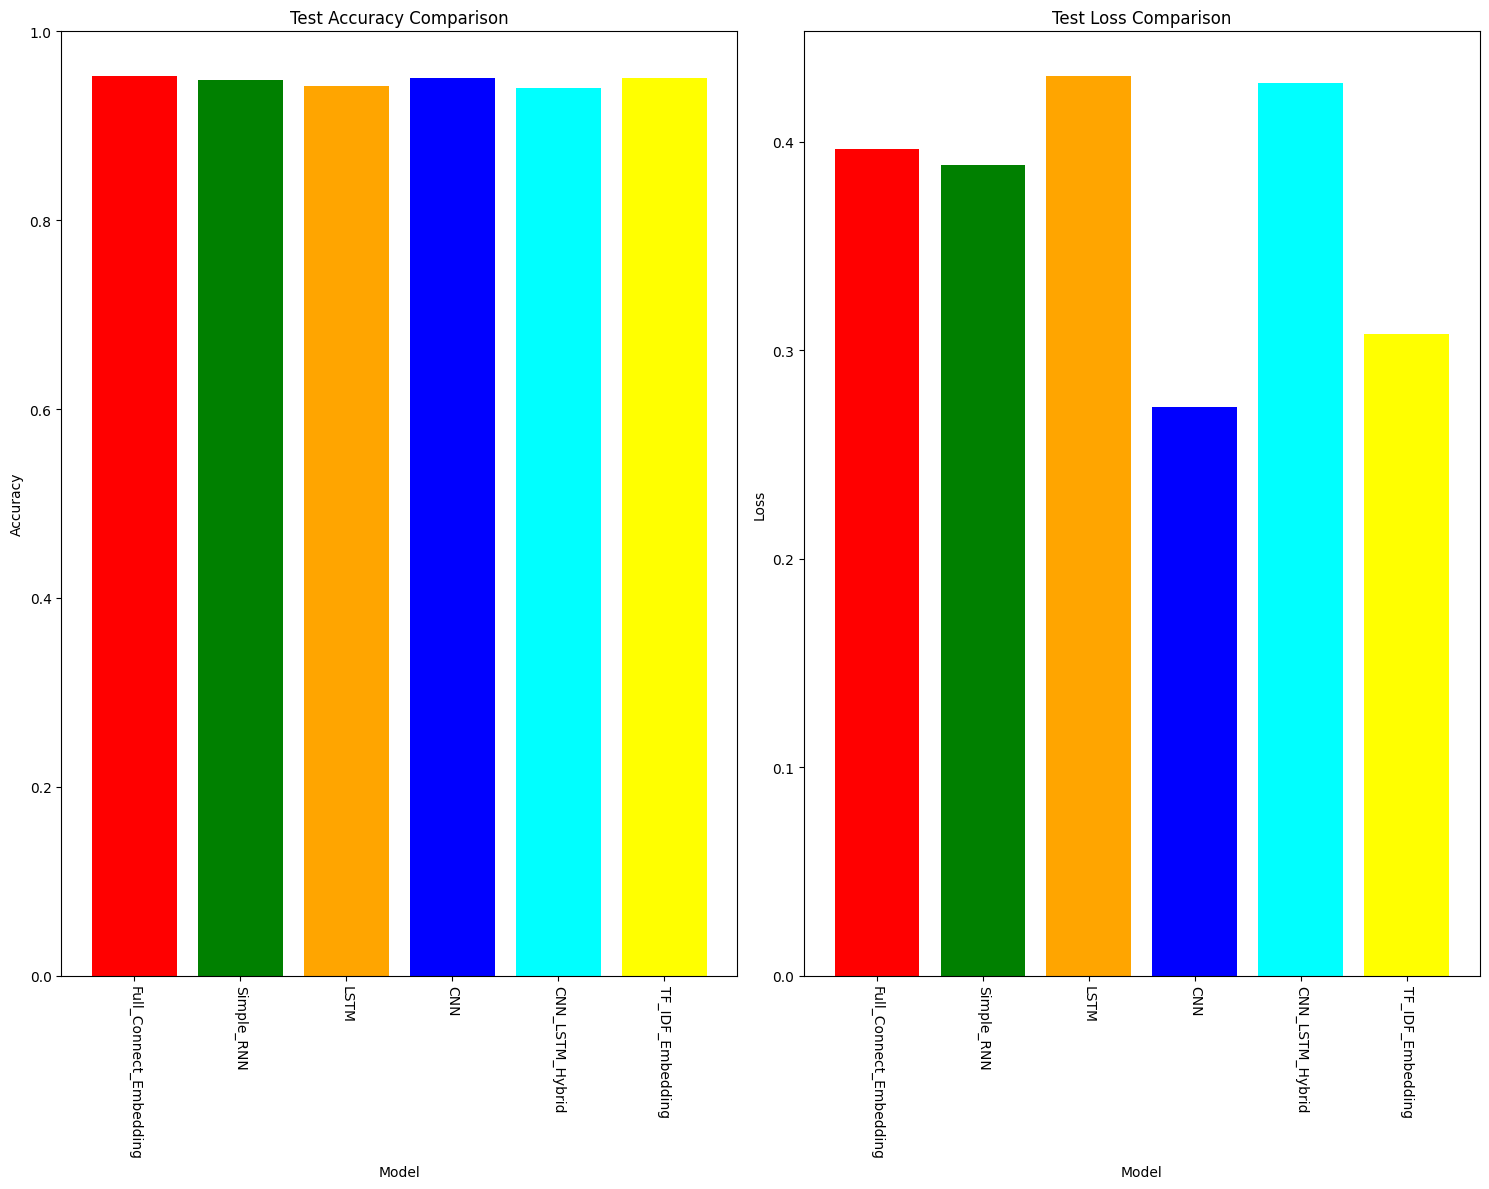

In [40]:
plt.figure(figsize=(15, 12))

model_names = list(test_accuracy_all.keys())
acc_values = list(test_accuracy_all.values())
plt.subplot(1, 2, 1)
bars = plt.bar(model_names, acc_values, color=['red', 'green', 'orange', 'blue', 'cyan', 'yellow'])
plt.xticks(rotation=-90, ha='center', fontsize=10)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')

model_names = list(test_loss_all.keys())
loss_values = list(test_loss_all.values())
plt.subplot(1, 2, 2)
bars = plt.bar(model_names, loss_values, color=['red', 'green', 'orange', 'blue', 'cyan', 'yellow'])
plt.xticks(rotation=-90, ha='center', fontsize=10)
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')

# Show the plot
plt.tight_layout()
plt.show()

It is found that all models show nearly no difference in accuracy on test set. The CNN-Embedding model yields the smallest mean loss and thus exhibits the most deterministic prediction. 

# 4. Summary and Outlook #

In this work, we developed and evaluated several simple neural networks for classifying sentiments within a large dataset of over 400,000 COVID-19 related tweets.

Our process began with extensive text preprocessing. This involved rigorous data cleaning, including the removal of misspellings, special characters, stop words, numbers, and text lemmatization. This comprehensive preprocessing successfully reduced the vocabulary size by over 50% compared to the original "clean tweets" column.

Following preprocessing, we constructed various sequential neural networks for supervised learning. These models accept the preprocessed text as input and output probabilities for positive, negative, and neutral sentiments. The models were categorized into two main groups:
1. Embedding-based models: These models vectorize text into integer sequences, which are then converted into a 2-dimensional embedding space.
2. TF-IDF based models: These models vectorize text into a TF-IDF array at the input layer.
Within the Embedding category, we explored several architectures, including fully-connected networks, Recurrent Neural Networks (RNN), Long Short-Term Memory (LSTM) networks, Convolutional Neural Networks (CNN), and CNN-LSTM hybrid models. For the TF-IDF category, we solely employed fully-connected layers to process the TF-IDF array input.

Notably, all developed models achieved similarly high accuracies (approximately 95%) across the training, validation, and test datasets. The only significant observed difference was that recurrent models (RNN, LSTM, and CNN-LSTM hybrid) exhibited slower learning speeds during training.

Based on these results, we can draw the following conclusions:
1. Sentiment Independence from Word Sequence/Context: On this specific dataset, tweet sentiment appears to be independent of word sequence or surrounding context. This is strongly supported by the TF-IDF model's performance, which, despite losing all sequential context information during its text vectorization, achieved the same high prediction accuracy on the test dataset as more complex models.
2. No Performance Advantage for Complex Embedding Models: Within the Embedding model group, CNNs and recurrent models demonstrated no discernible advantage in prediction performance or parameter size compared to the simpler fully-connected model. This observation likely stems from the same independence of sentiment on word sequence or context. Furthermore, given that tweets are generally very short (containing a maximum of approximately 30 words), the fully-connected model does not incur an excessive number of parameters by connecting all words to the output dimensions.


## 4.1 Further Improvement ##

Based on the diverse model test results, it appears that a 95% accuracy serves as an approximate upper bound for sentiment classification when the input is limited to only preprocessed tweet text.

To potentially achieve higher sentiment classification accuracy, future work could investigate these avenues:
1. Re-evaluate Misspelling Handling: Consider retaining misspelled words during text vectorization. It is plausible that even "non-standard" or informal word forms contribute to sentiment expression and should not be discarded.
2. Multi-Modal Feature Integration: Construct a more sophisticated model that not only processes the clean tweet text but also learns sentiment from complementary sources like hashtags and other available columns such as retweet and favorite counts. This could involve an architecture where multiple specialized models process distinct input types concurrently, with their predictions or embeddings subsequently combined.